In [1]:
import pandas as pd
import numpy as np

In [2]:
train=pd.read_parquet("../Data/train_final_v3.parquet")
valid=pd.read_parquet("../Data/validationA_v3.parquet")

In [3]:
features=[col for col in train.columns if col!='match']

X_train=train[features]
y_train=train.match

X_val=valid[features]
y_val=valid.match

In [4]:
# Group columns by data_type
from pandas.api.types import is_numeric_dtype, is_bool_dtype,is_datetime64_any_dtype,is_timedelta64_dtype,is_categorical_dtype,is_object_dtype
review_embedding_cols=[col for col in features if col[0:6]=='embed_']
summary_embedding_cols=[col for col in features if col[0:10]=='embedding_']
bool_cols=[col for col in X_train.columns if is_bool_dtype(X_train[col])]
datetime_cols=[col for col in X_train.columns if is_datetime64_any_dtype(X_train[col])]
timedelta_cols=[col for col in X_train.columns if is_timedelta64_dtype(X_train[col])]
numerical_cols=[col for col in X_train.columns if is_numeric_dtype(X_train[col]) and col not in review_embedding_cols+summary_embedding_cols+bool_cols]
categorical_cols=[col for col in X_train.columns if is_object_dtype(X_train[col])]

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [23]:
from sklearn.metrics import (classification_report,ConfusionMatrixDisplay,
                             balanced_accuracy_score,precision_recall_curve,
                             make_scorer,average_precision_score)
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pylab as plt
def evaluate(model,y_true_train,y_pred_train,y_true_val,y_pred_val,y_pred_val_proba):
    # Get coefficients of fitted model
    coefficients=pd.DataFrame({
        'feature':model[-3].get_feature_names_out(),
        'coefficient':model[-1].coef_[0]}) 

    # Metrics on training data
    print(f"On training data:")
    bal_ac=balanced_accuracy_score(y_true_train,y_pred_train)
    print(f"Balanced accuracy score: {bal_ac}")
    report=classification_report(y_true_train,y_pred_train)
    print(report)
    ConfusionMatrixDisplay.from_predictions(y_true_train,y_pred_train)
    plt.show()
    
    # Metrics on validation data
    bal_ac=balanced_accuracy_score(y_true_val,y_pred_val)
    print(f"On validation data:")
    # print(f"Accuracy score: {acc}")
    # print(f"Balanced accuracy score: {bal_ac}")
    # print(f"F1 score: {f1}")
    report=classification_report(y_true_val,y_pred_val)
    print(report)
    ConfusionMatrixDisplay.from_predictions(y_true_val,y_pred_val)
    plt.show()


    plt.figure(figsize=(10, 6))
    plt.barh(range(30), coefficients.coefficient)
    plt.yticks(range(30), coefficients.feature)
    plt.title("Top Logistic Regression Coefficients")
    plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
    plt.tight_layout()
    plt.show()



    sample_weights = compute_sample_weight(class_weight='balanced', y=y_true_val)

    # Compute weighted precision-recall
    precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_val_proba, sample_weight=sample_weights)

    # No-skill line: weighted proportion of positives
    no_skill = np.average(y_true_val, weights=sample_weights)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Weighted PR Curve')
    plt.hlines(no_skill, 0, 1, colors='r', linestyles='--', label='No Skill (Weighted)')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Weighted Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [7]:
# Initialize the pre-determined kfold generator, to be used in GridSearchCV etc.
# IMPORTANT: This can only be used a model fitted on (X,y) 
# whenever rows of X correspond to rows of X_train

import sys
sys.path.insert(0, '../Data/')
from get_cv_split import PredefinedKFold
split_data=pd.read_parquet("../Data/CV_val_split.parquet")
assert((split_data.index==X_train.index).all()) # Sanity check to verify indices of X_train match up with indices of split_data
kfold=PredefinedKFold(split_data)

In [38]:
column_preprocessing=make_column_transformer(
    (OneHotEncoder(feature_name_combiner='concat'),['category']),
    (PCA(n_components=20),review_embedding_cols),
    (PCA(n_components=20),summary_embedding_cols),
    ('drop',datetime_cols+timedelta_cols),
    remainder='passthrough'
)
log_reg=LogisticRegression(class_weight='balanced')
model_cv=make_pipeline(
    column_preprocessing,
    StandardScaler(),
    log_reg
    )
model_cv

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['category']),
                                                 ('pca-1', PCA(n_components=20),
                                                  ['embed_0', 'embed_1',
                                                   'embed_2', 'embed_3',
                                                   'embed_4', 'embed_5',
                                                   'embed_6', 'embed_7',
                                                   'embed_8', 'embed_9',
                                                   'embed_10', 'embed_11',
                                                   'embed_12', 'embed_13',
                                                   'embed_14', 'embed_15',
                                                   'embed_16', 'e...
                                                   'embedding_18',
                                                   'embedding_19',
                                                   'embedding_20',
                                                   'embedding_21',
                                                   'embedding_22',
                                                   'embedding_23',
                                                   'embedding_24',
                                                   'embedding_25',
                                                   'embedding_26',
                                                   'embedding_27',
                                                   'embedding_28',
                                                   'embedding_29', ...]),
                                                 ('drop', 'drop',
                                                  ['min_date', 'max_date',
                                                   'product_lifespan'])])),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

In [9]:

def weighted_pr_auc(y_true, y_pred_proba, **kwargs):
    from sklearn.metrics import average_precision_score
    return average_precision_score(y_true, y_pred_proba, average='weighted')

weighted_pr_auc_scorer = make_scorer(weighted_pr_auc, needs_proba=True)

In [10]:
def GridSearchComponennts(scorer):
    final_model = GridSearchCV(
    model_cv,
    param_grid={
    'columntransformer__pca-1__n_components':[0,5,10,20,50,100],
    'columntransformer__pca-2__n_components':[0,5,10,20,50,100]
    },
    scoring=scorer,
    cv=kfold
    )
    final_model.fit(X_train,y_train)
    y_pred_tt=final_model.predict(X_train)
    y_pred_val=final_model.predict(X_val)
    y_pred_val_proba=final_model.predict_proba(X_val)[:,1]
    for x,y in final_model.best_params_.items():
        print(f"{x}: {y}")
    evaluate(final_model.best_estimator_,y_train,y_pred_tt,y_val,y_pred_val,y_pred_val_proba)

columntransformer__pca-1__n_components: 10
columntransformer__pca-2__n_components: 100
On training data:
Balanced accuracy score: 0.8441562499999999
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    112000
           1       0.03      0.87      0.06       768

    accuracy                           0.82    112768
   macro avg       0.52      0.84      0.48    112768
weighted avg       0.99      0.82      0.90    112768



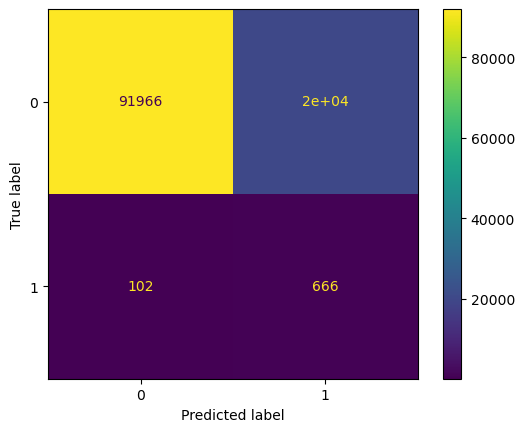

On validation data:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     24000
           1       0.03      0.70      0.05       164

    accuracy                           0.82     24164
   macro avg       0.51      0.76      0.47     24164
weighted avg       0.99      0.82      0.89     24164



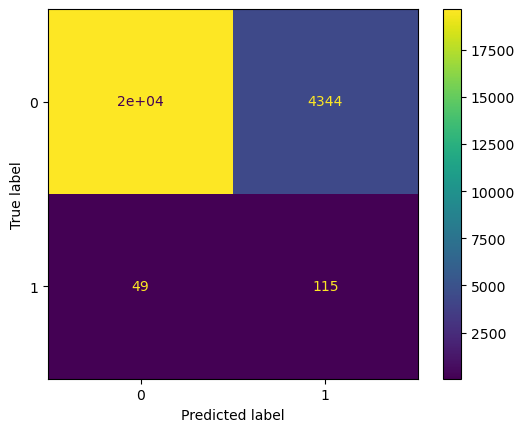

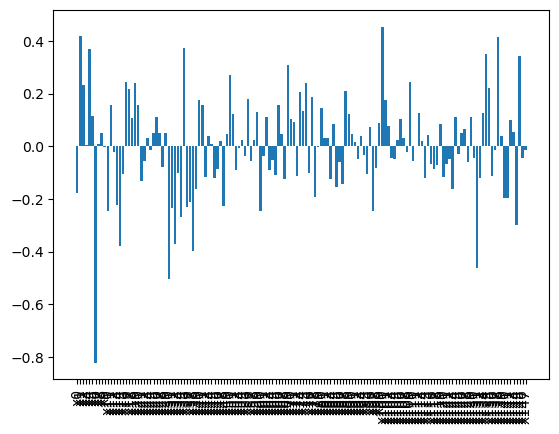

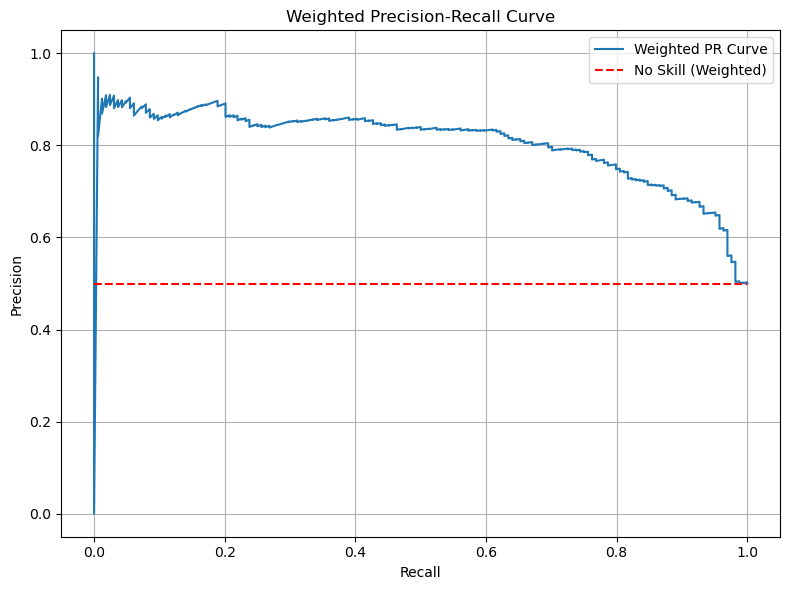

In [11]:
GridSearchComponennts(weighted_pr_auc_scorer)

columntransformer__pca-1__n_components: 10
columntransformer__pca-2__n_components: 100
On training data:
Balanced accuracy score: 0.8441562499999999
              precision    recall  f1-score   support

           0       1.00      0.82      0.90    112000
           1       0.03      0.87      0.06       768

    accuracy                           0.82    112768
   macro avg       0.52      0.84      0.48    112768
weighted avg       0.99      0.82      0.90    112768



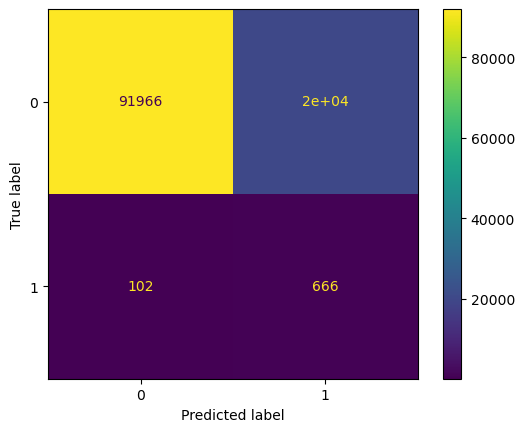

On validation data:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     24000
           1       0.03      0.70      0.05       164

    accuracy                           0.82     24164
   macro avg       0.51      0.76      0.47     24164
weighted avg       0.99      0.82      0.89     24164



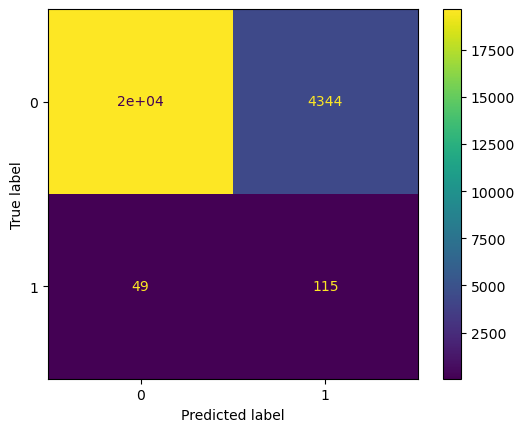

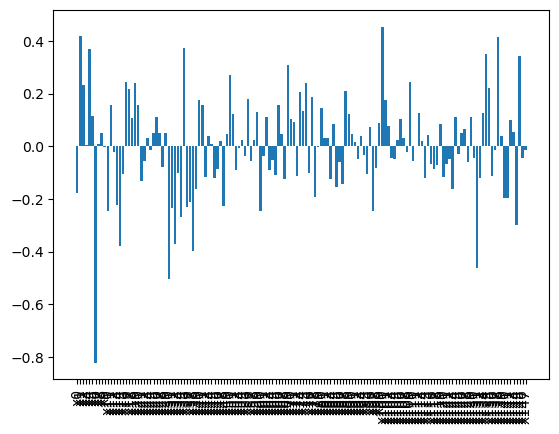

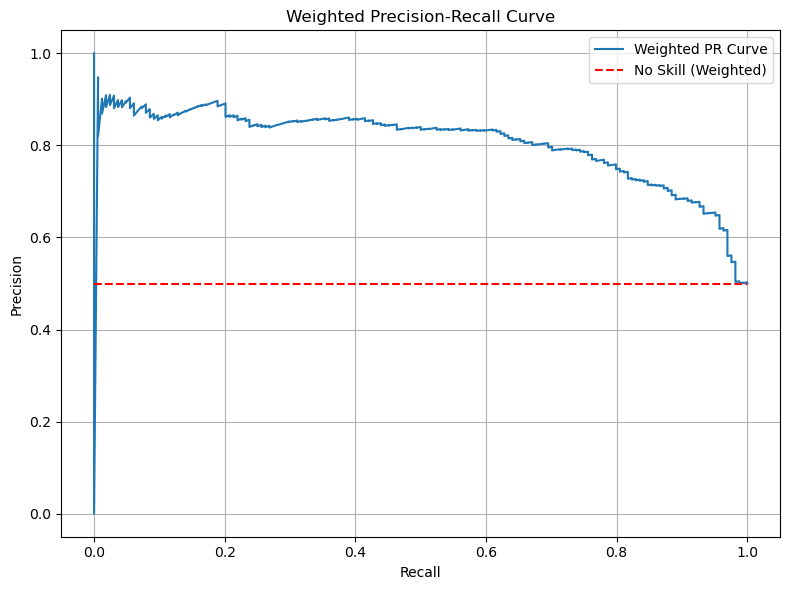

In [13]:
GridSearchComponennts('f1')

columntransformer__pca-1__n_components: 0
columntransformer__pca-2__n_components: 10
On training data:
Balanced accuracy score: 0.8065669642857143
              precision    recall  f1-score   support

           0       1.00      0.79      0.88    112000
           1       0.03      0.83      0.05       768

    accuracy                           0.79    112768
   macro avg       0.51      0.81      0.46    112768
weighted avg       0.99      0.79      0.87    112768



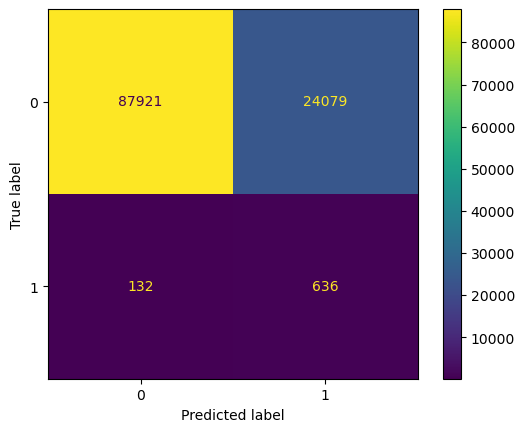

On validation data:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     24000
           1       0.03      0.82      0.05       164

    accuracy                           0.78     24164
   macro avg       0.51      0.80      0.46     24164
weighted avg       0.99      0.78      0.87     24164



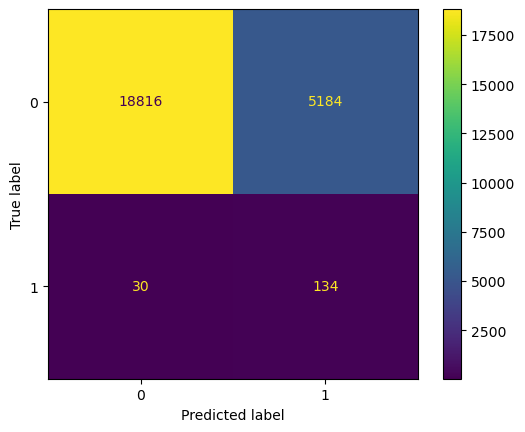

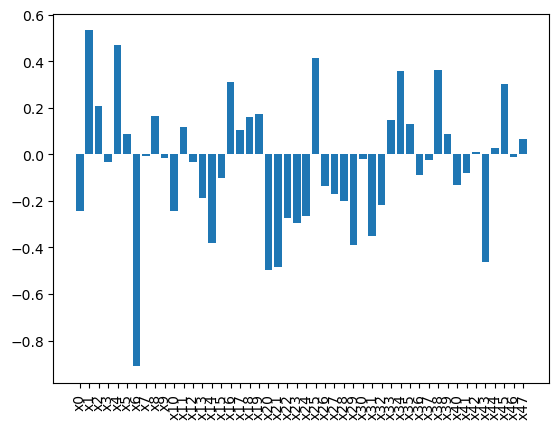

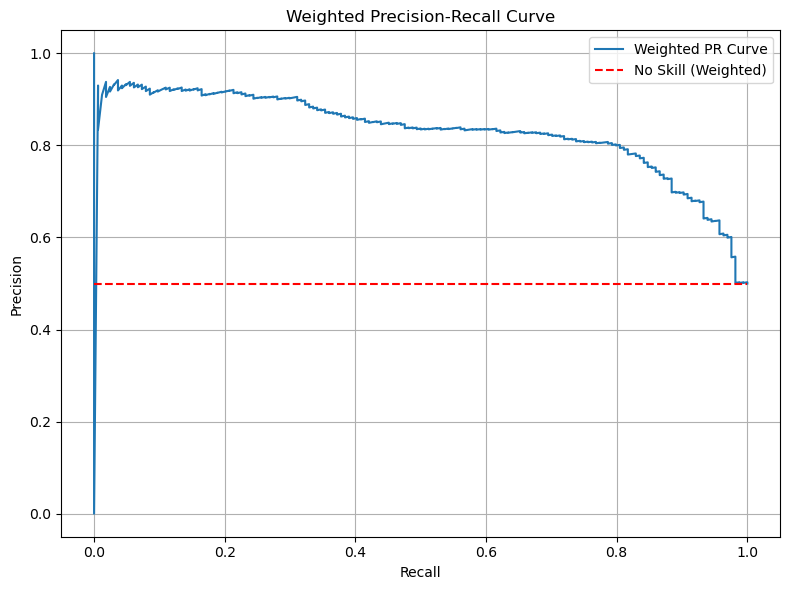

In [14]:
GridSearchComponennts('recall')